# Portfolio Optimization

Haiyang Yu, 04/13/2018

Contents:
+ Foundamental concepts
+ Markowitz Modern Portfolio Theory
+ Factor model
+ Expectation-Maximization (EM) algorithm
+ Rejection sampling method
+ Random walk Monte Carlo sampling method


## Foundamental concepts

- **Rate of Return**
    - In finance, return is a profit on an investment. Rate of return is a profit on an investment over a period of time, expressed as a proportion of the original investment. The time period is typically a year, in which case the rate of return is referred to as annual return. To compare returns over time periods of different lengths on an equal basis, it is useful to convert each return into an annualised return. This conversion process is called **annualisation**.

    $$ r_t = \frac{S_t - S_{t-1}}{S_{t-1}} $$
    
    - Annualisation:
        + Without any reinvestment, a return $R$ over a period of length $t$ (unit: year) is equivalent to a rate of annual return: $r=R/t$
        + If the reinvestment is considerred, due to the effect of compounding, the relationship between a rate of return $r$, and a return $R$ over a length of time $t$ is: $(1+R) = (1+r)^t$

    - log-return: 
        + logarithmic return from initial value ($V_i$) to the future value ($V_f$): $\ln(V_f/V_i)$
        + logarithmic rate of return: $r_{log} = \ln(V_f/V_i)/t$
        + Asset growth equation: $V_f = V_i e^{rt}$

    - Internal Rate of Return (IRR): 
        + The rate of return which makes the net present value (NPV) of cash flows zero. 
        + It is a solution $r$ satisfying the following equation:
            $$ NPV = \sum_{t=0}^{n} \frac{C_t}{(1+r)^t} $$
        + Example: An investment is given by the sequence of cash flows, IRR should be 5.96%. 
            
Year (t)  |  Cash flow ($C_t$)
----------|-------------------
0 |  -123400
1 |  36200
2 |  54800
3 |  48100


- **Risk**
    + The Golden Law of finance: high returns are often associated with high risks.
    + Risks are the uncertainties of returns, like the error bars of measurements.
    + Volatility:
        - In finance, volatility (symbol σ) is the degree of variation of a trading price series over time as measured by the standard deviation of logarithmic returns.
        - Historic volatility is derived from time series of past market prices. An implied volatility is derived from the market price of a market traded derivative (in particular an option).
        - For a financial instrument whose price follows a Gaussian random walk, or Wiener process, the width of the distribution increases as time increases. This is because there is an increasing probability that the instrument's price will be farther away from the initial price as time increases. However, rather than increase linearly, the volatility increases with the square-root of time as time increases, because some fluctuations are expected to cancel each other out, so the most likely deviation after twice the time will not be twice the distance from zero.
        - Since observed price changes do not follow Gaussian distributions, others such as the Lévy distribution are often used. These can capture attributes such as "fat tails". Volatility is a statistical measure of dispersion around the average of any random variable such as market parameters etc.
        - Much research has been devoted to modeling and forecasting the volatility of financial returns, and yet few theoretical models explain how volatility comes to exist in the first place.
        - Volatility is not always the bad thing; sometimes it can bring profits (e.g. trading volatility).

- **Risk Free Rate**
    + Theoretical rate of return of an investment with zero risk over a given period of time.
    + e.g. risk-free bonds, issued by government of agency whose risks of default are so low as to be negligible.
    + e.g. United States Treasury security: https://en.wikipedia.org/wiki/United_States_Treasury_security#Treasury_bond
    + https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield

- **Arbitrage**
    + In economics and finance, arbitrage is the practice of taking advantage of a price difference between two or more markets: striking a combination of matching deals that capitalize upon the imbalance, the profit being the difference between the market prices. 
    + Arbitrage-free: If the market prices do not allow for profitable arbitrage, the prices are said to constitute an arbitrage equilibrium, or arbitrage-free market. An arbitrage equilibrium is a precondition for a general economic equilibrium. The "no arbitrage" assumption is used in quantitative finance to calculate a unique risk neutral price for derivatives.
    
- **Efficient-market hypothesis**
    + Asset prices fully reflect all available information. 
    + A direct implication is that it is impossible to "beat the market" consistently on a risk-adjusted basis since market prices should only react to new information.
    + Efficient-market is also an arbitrage-free market.


without reinvestment: r = 0.5
with reinvestment: r = 0.19623119885131546


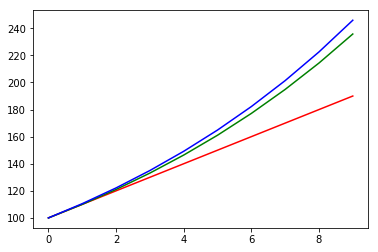

In [16]:
t = 10
R = 5.0
print('without reinvestment: r =', R/t )
print('with reinvestment: r =', (1+R)**(1.0/t)-1 )

PV = 100.0
r  = 0.10  # annual return
nt = 10    # years
t = np.arange(10)
FV1 = PV * (1+r*t)
k = 1
FV2 = PV * (1+r/k)**(k*t)
k = 365000
FV3 = PV * (1+r/k)**(k*t)
plt.plot(t, FV1, 'r')
plt.plot(t, FV2, 'g')
plt.plot(t, FV3, 'b')


0.10517091807564771


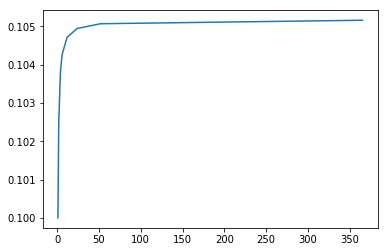

In [24]:
# relationship of R v.s. k
ks = np.array([1,2,4,6,12,24,52,365])
r = 0.1
plt.plot(ks, (1+r/ks)**(ks)-1)
print(np.exp(r)-1)

In [7]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})

def add_logreturn(quote, n=[0, 1], ):
    # n --- 0: in-day logreturn (Close/Open); 
    #       1: 1-day logreturn (Adj Close); 
    #       k: k-day logreturn (Adj Close)
    ntime = len(quote)
    logadj = np.array( np.log( quote.loc[:,'Adj Close'].astype('float') ))
    for i in n:
        quote.loc[:,'logreturn_'+format(i)] = np.zeros([ntime]) + np.nan
        if i==0:
            quote.loc[:,'logreturn_0'] = np.log(quote.loc[:, 'Close'].astype('float'))  - \
                np.log(quote.loc[:, 'Open'].astype('float')) 
        else:
            #quote['logreturn_'+format(i)].values[i:ntime] = logadj[i:ntime] - logadj[0:ntime-i]
            quote.loc[quote.index[i:ntime], 'logreturn_'+format(i)] = logadj[i:ntime] - logadj[0:ntime-i]
    return quote

In [28]:
# Internal Rate of Return
import numpy as np
np.irr([-123400, 36200, 54800, 48100])

0.0596163785673296

$X(t) = X(t-1) + Z(t)$, where $Z(t)$ ~ any distribuion with $E(Z)=0, Var(Z)=\sigma^2$

$E(\bar{Z}) = \overline{E(Z)} = 0$

$Var(\bar{Z}) = E(\bar{Z}^2) - E^2(\bar{Z}) = \sigma^2/t$

$\bar{Z}$ ~ $N(0, \sigma^2/t)$

$X(t) = t \bar{Z}$

$X(t)$ ~ $N(0, \sigma^2 t)$

$std(X(t)) = \sigma \sqrt{t}$


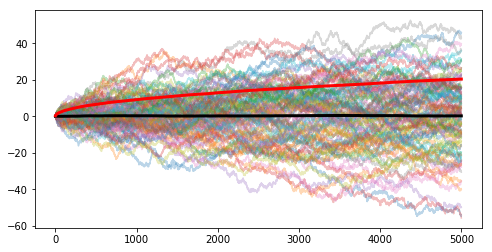

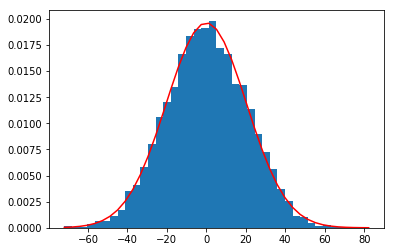

In [36]:
# Volatilities in Gaussian random walk (Wiener process)
# Moving-Average model: 
# x(t) = x(t-1) + z(t), where z(t) ~ N(0, sigma^2)
# z(0) = 0
# MZ(t) = sum(z(i), i=0,1,2,...,t)/t
# E(MZ(t)) = sum(E(z(i)))/t = 0
# MZ(t) ~ Norm(0, sigma^2  1/t)  # CLT
# X(t) = t*MZ(t) ~ Norm(0, sigma^2 = t^2/t) 
#      = Norm(0, sigma^2 = t) # 

ntime = 5000; nexp = 5000
#data = np.cumsum( stats.norm.rvs(size= \
#             ntime*nexp).reshape([nexp, ntime]), axis=1 )
data = np.cumsum( stats.uniform.rvs(loc=-0.5, scale=1, size= \
             ntime*nexp).reshape([nexp, ntime]), axis=1 )

dmean = np.mean(data, axis=0)
dstd  = np.std(data, axis=0)

plt.figure(1, figsize=(8, 4))
for i in range(100):
    plt.plot(data[i,:], alpha=0.3)
plt.plot(dmean,'k', linewidth=3)
plt.plot(dstd,'r', linewidth=3)
plt.show()

plt.figure(2)
dpdf = plt.hist(data[:, -1], 40, density=True)
plt.plot(dpdf[1], stats.norm.pdf(dpdf[1], 
                 loc=0, scale=np.std(data[:,-1])), 'r')

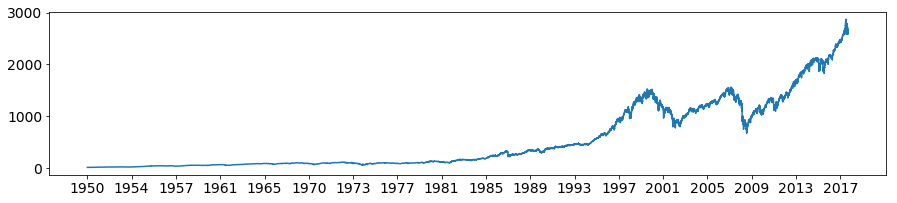

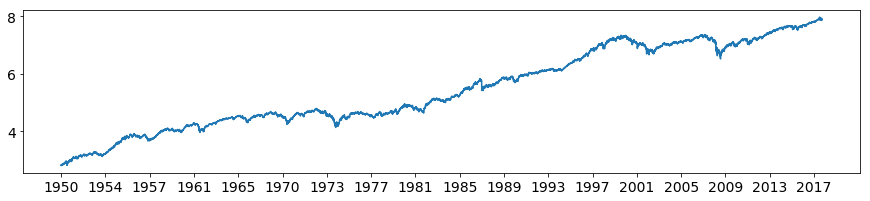

In [103]:
# Volatility
sp = pd.read_csv('sp500.csv')
ntime = len(sp)

plt.figure(1, figsize=(15,3))
plt.plot( sp['Adj Close'] )
plt.xticks(range(ntime)[::1000], [s[:4] for s in sp['Date'][::1000]] )
plt.show()

plt.figure(1, figsize=(15,3))
plt.plot( np.log(sp['Adj Close']) )
plt.xticks(range(ntime)[::1000], [s[:4] for s in sp['Date'][::1000]] )
plt.show()

In [104]:
sp.index = pd.to_datetime( sp['Date'] )
sp = add_logreturn(sp)
sp.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,logreturn_0,logreturn_1
Date,,,,,,,,,
1950-01-03,1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000,0.000000,NaN
1950-01-04,1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000,0.000000,0.011340
1950-01-05,1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000,0.000000,0.004737
1950-01-06,1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000,0.000000,0.002949
1950-01-09,1950-01-09,17.09,17.09,17.08,17.08,17.08,3850000,-0.000585,0.005872


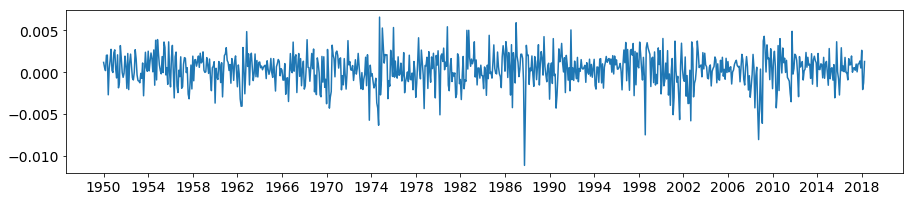

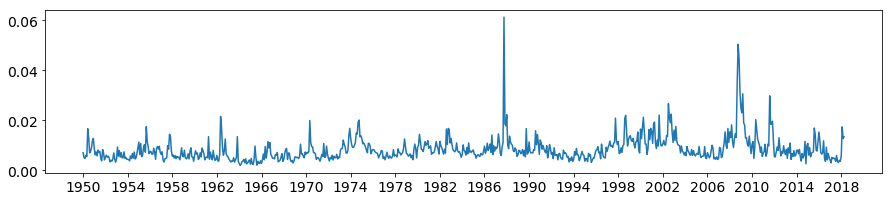

In [105]:
spm = sp.resample('M').mean()[['logreturn_1']]
spm['volatility'] = sp.resample('M').std()[['logreturn_1']]
spm['logvolatility'] = np.log(spm['volatility'])
nmonth = len(spm)

plt.figure(1, figsize=(15,3))
plt.plot(range(nmonth), spm['logreturn_1'] )
plt.xticks(range(nmonth)[::48], [s.year for s in spm.index[::48]] )
plt.show()

plt.figure(2, figsize=(15,3))
plt.plot(range(nmonth), spm['volatility'] )
plt.xticks(range(nmonth)[::48], [s.year for s in spm.index[::48]] )
plt.show()

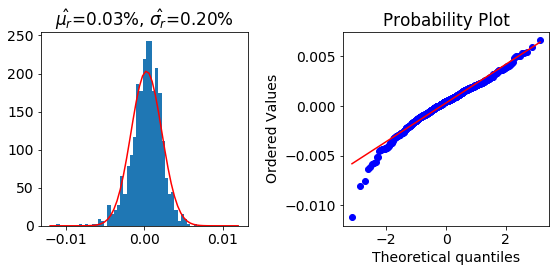

In [139]:
bins = np.linspace(-0.012, 0.012, 60)
plt.figure(1, figsize=(8,4))
plt.subplot(1,2,1)
pdf = plt.hist(spm['logreturn_1'], bins=bins, density=True)
plt.plot(bins, stats.norm.pdf(bins, loc=np.mean(spm['logreturn_1']), 
                              scale=np.std(spm['logreturn_1'])), 'r')
plt.title('$\hat{\mu_r}$='+format(np.mean(spm['logreturn_1'])*100,'.2f')+ \
         '%, $\hat{\sigma_r}$='+format(np.std(spm['logreturn_1'])*100, '.2f')+'%' )

tmp = stats.probplot(spm['logreturn_1'], plot=plt.subplot(1,2,2))
plt.tight_layout()


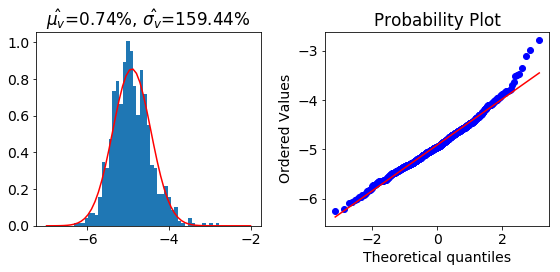

In [140]:
bins = np.linspace(-7, -2, 60)
plt.figure(1, figsize=(8,4))
plt.subplot(1,2,1)
var = 'logvolatility'
pdf = plt.hist(spm[var], bins=bins, density=True)
plt.plot(bins, stats.norm.pdf(bins, loc=np.mean(spm[var]), 
                              scale=np.std(spm[var])), 'r')
plt.title('$\hat{\mu_v}$=' + format(np.exp(np.mean(spm[var]))*100,'.2f')+ \
         '%, $\hat{\sigma_v}$='+format(np.exp(np.std(spm[var]))*100, '.2f')+'%' )

tmp = stats.probplot(spm[var], plot=plt.subplot(1,2,2))
plt.tight_layout()


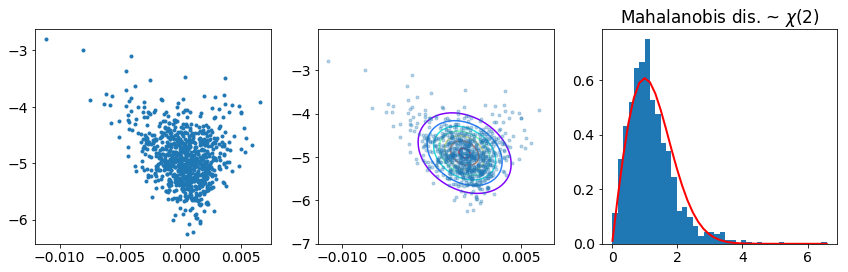

In [138]:
plt.figure(1, figsize=(12, 4))
plt.subplot(1,3,1)
plt.plot(spm['logreturn_1'], spm['logvolatility'], '.')

plt.subplot(1,3,2)
xx, yy = np.mgrid[-0.012:0.008:0.0002, -7:-2:0.05]
pos = np.dstack((xx,yy))
spm2 = spm[['logreturn_1', 'logvolatility']]
mu = spm2.mean(axis=0)
cov = np.dot((spm2 - mu).T, spm2 - mu)/len(spm)
z = stats.multivariate_normal.pdf(pos, mean=mu, cov=cov)
plt.contour(xx, yy, z, 8, cmap='rainbow')
plt.plot(spm['logreturn_1'], spm['logvolatility'], '.', alpha=0.3)

plt.subplot(1,3,3)
dis = np.sqrt( np.sum(np.dot((spm2-mu), np.linalg.inv(cov)) * (spm2-mu), axis=1) )
dpdf = plt.hist(dis, 40, density=True)
plt.plot(dpdf[1], stats.chi.pdf(dpdf[1], df=2), 'r', lw=2)
plt.title('Mahalanobis dis. ~ $\chi(2)$')

plt.tight_layout()

/home/oscar/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


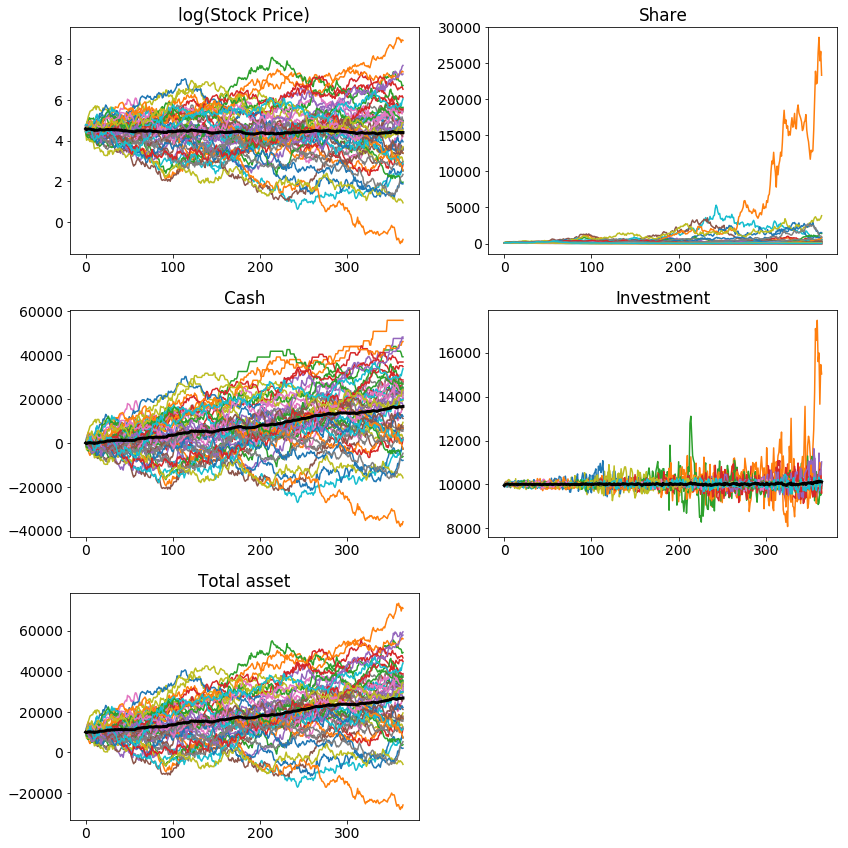

In [188]:
# A simple trading model on volatility
def simpletrade(ts, cash):
    share = np.zeros([len(ts)]).astype(int)
    asset = np.zeros([len(ts), 2])  # 0: cash, 1: investment
    share[0] = int(cash/ts[0])
    asset[0,1] = share[0]*ts[0]
    asset[0,0] = cash - asset[0,1]
    maintain = cash
    for i in range(1,len(ts)):
        if ts[i] > ts[i-1]:
            nsell = int(abs(ts[i]*share[i-1] - maintain)/ts[i])
            share[i] = share[i-1] - nsell
            asset[i,0] = asset[i-1,0] + nsell*ts[i]
        else:
            nbuy = int(abs(ts[i]*share[i-1] - maintain)/ts[i])
            share[i] = share[i-1] + nbuy
            asset[i,0] = asset[i-1,0] - nbuy*ts[i]
        asset[i,1] = share[i]*ts[i]
    return share, asset

ntime = 365; nexp = 50; s0 = np.log(100.0); mu = 0; vola = 0.1
cash = 1e4

ss = np.exp( s0 + np.cumsum(stats.norm.rvs(loc=0, scale=vola, 
        size=ntime*nexp).reshape([nexp, ntime]), axis=1) )
assetmean = np.zeros([ntime, 2])

plt.figure(1, figsize=(12, 12))
for i in range(nexp):
    plt.subplot(3,2,1)
    plt.plot(np.log(ss[i,:]) )
    plt.title('log(Stock Price)')
    
    share, asset = simpletrade(ss[i,:], cash=cash)
    assetmean += asset
    plt.subplot(3,2,2)
    plt.plot( share )
    plt.title('Share')

    plt.subplot(3,2,3)
    plt.plot( asset[:, 0] )
    plt.title('Cash')

    plt.subplot(3,2,4)
    plt.plot( asset[:, 1] )
    plt.title('Investment')

    plt.subplot(3,2,5)
    plt.plot( np.sum(asset, axis=1) )
    plt.title('Total asset')

plt.subplot(3,2,1)
plt.plot( np.mean(np.log(ss), axis=0), 'k', linewidth=3 )

plt.subplot(3,2,3)
plt.plot( assetmean[:, 0]/nexp, 'k', linewidth=3 )

plt.subplot(3,2,4)
plt.plot( assetmean[:, 1]/nexp, 'k', linewidth=3 )

plt.subplot(3,2,5)
plt.plot( np.sum(assetmean, axis=1)/nexp, 'k', linewidth=3 )
    
plt.tight_layout()
plt.show()

## Markowitz Modern Portfolio Theory

Modern portfolio theory (MPT), or mean-variance analysis, is a mathematical framework for assembling a portfolio of assets such that the expected return is maximized for a given level of risk. It uses the variance of asset prices as a proxy for risk.

Economist Harry Markowitz introduced MPT in a 1952 essay, for which he was later awarded a Nobel Prize in economics.

### Multivariate Normal Distribution Assumption

The asset returns $X = (X_1, X_2, ..., X_k)^T$ follow a multivariate normal distribution:

$$ f(\vec{x}) = \frac{1}{\sqrt{(2\pi)^k |\Sigma|} } \exp [-\frac{1}{2} (\vec{x}-\vec{\mu})^T \Sigma^{-1} (\vec{x}-\vec{\mu})] $$

Each random variable follows a normal distribution: $X_i$ ~ $N(\mu_i, \sigma_i^2)$

Mean vector $\vec{\mu} = (E(X_1), E(X_2), ..., E(X_k))^T = (\mu_1, \mu_2, ..., \mu_k)^T$

Covariance matrix $\Sigma = \{ Cov[X_i, X_j] \} = \{ \rho_{ij} \sigma_i \sigma_j \}, (\rho_{ii}=1; i,j=1,2,...,k)$

### Mean-Variance optimization

- **Allocation**: portfolio weights for each asset $\vec{w} = (w_1, w_2, ..., w_k)$.

- **Portfolio mean (return)** (reward): 

    $$\mu_p = \vec{\mu}^T \vec{w}$$

- **Portfolio variance** (risk): 

    $$\sigma_p^2 = \vec{w}^T \Sigma \vec{w}$$

- **Optimization**: 

    $$ \min_{\vec{w}} \{ Risk - \lambda * Reward \ | \  \vec{w} \in S \} $$
    + $S$ is the feasible set;
    + $\lambda \in [0, +\infty)$ represents the trade-off between reward and risk;
    + $\lambda \to 0$: conservative manager who doesn't like any risk;
    + $\lambda \to \infty$: greedy manager who wants rewards as much as possible but doesn't care about risk.
    
- **Standard form: quadratic optimization**

    $$ M = \min_\vec{w}  ( \frac{1}{2}\vec{w}^T \Sigma \vec{w} - \lambda \vec{\mu}^T \vec{w} ) $$
    
    $$ s.t. \sum{\vec{w}} = \vec{1}^{T} \vec{w} = 1 $$
    
- **Lagrange multiplier**
     $$L(M) = \frac{1}{2}\vec{w}^T \Sigma \vec{w} - \lambda \vec{\mu}^T \vec{w} - \zeta (\vec{1}^T \vec{w} - 1) $$

    + Let the gradient be zero $\nabla L(M) = \Sigma \vec{w} - \lambda \vec{\mu} - \zeta \vec{1} = 0 $, then we can get the solution:
    
    $$ \vec{w} = \lambda \Sigma^{-1} \vec{\mu} + \zeta \Sigma^{-1} \vec{1}  $$
    
    + Let $\lambda$ be fixed, substitute the above solution in the constraint to get the Lagrange multiplier:
    
    $$ \zeta = \frac{1-\lambda \vec{1} \Sigma^{-1} \vec{\mu}}{\vec{1} \Sigma^{-1} \vec{1}} $$
    
    + Then substitute it into the solution for $\vec{w}$, we get the **efficient frontier** parameterized by $\lambda$:
    
    $$ \vec{w} = \lambda \Sigma^{-1} \mu + \left( \frac{1-\lambda \vec{1} \Sigma^{-1} \vec{\mu}}{\vec{1} \Sigma^{-1} \vec{1}} \right) \Sigma^{-1} \vec{1}  $$
    
        - If $\lambda = 0$, we get the Minimum Variance Portfolio:
        
            $$ \vec{w} = \frac{\Sigma^{-1}\vec{1}}{\vec{1}^T \Sigma^{-1} \vec{1}} $$

    + Efficient frontier (or portfolio frontier) is an investment portfolio which occupies the 'efficient' parts of the risk-return spectrum. 


**References**

https://en.wikipedia.org/wiki/Modern_portfolio_theory

https://en.wikipedia.org/wiki/Efficient_frontier



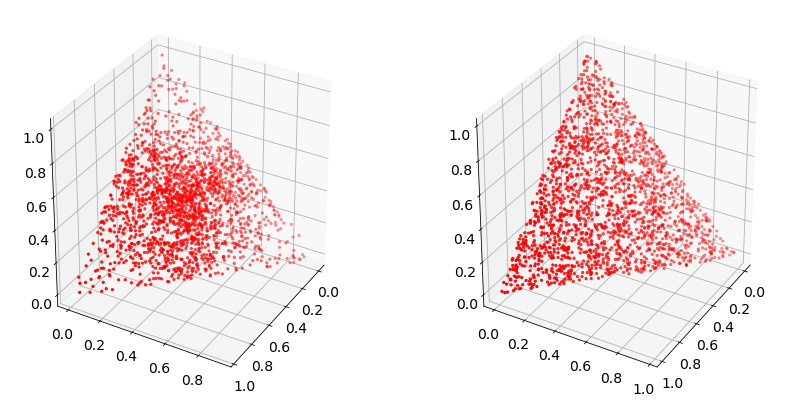

In [190]:
from mpl_toolkits.mplot3d import Axes3D

def sampling_weight(nx=3, nsp=10, flag=1):
    # uniform distributed samping with constrain: sum(x) = 1
    # nx: number of random variables
    # nsp: number of sampling points
    
    if flag==0:
        # Naive normalized method: NOT uniformly distributed on the simplex
        p = np.random.uniform(low=0, high=1, size=nx*nsp).reshape(nsp, nx)
        p = p / np.sum(p, axis=1).reshape(nsp,1)

    if flag==1:
        # Symmetric Dirichlet distribution: uniformly distributed on the simplex
        p = np.random.exponential(scale=1, size=nx*nsp).reshape(nsp, nx)
        p = p / np.sum(p, axis=1).reshape(nsp,1)
        
    return p 

plt.figure(1, figsize=(14,7))
for i in range(2):
    ax = plt.subplot(1,2,i+1, projection='3d')
    p = sampling_weight(nx=3, nsp=2000, flag=i)
    ax.scatter(p[:,0], p[:,1], p[:,2], c='r', s=20, marker='.')
    ax.view_init(30, 30)

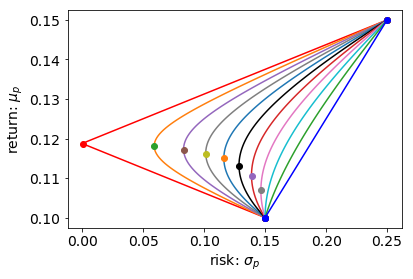

In [235]:
# cases of two assets

def plot_2s(r=[0.1, 0.15], s=[0.28, 0.24], cor=-0.1, cstr='r', lstr='-', 
            w=np.array([np.linspace(1,0,100), np.linspace(0,1,100)])):
    pr = np.dot(np.array(r).reshape([1,2]), w)[0]
    cormat = np.array([[s[0]*s[0], cor*s[0]*s[1]], [cor*s[0]*s[1], s[1]*s[1]]])
    ps = np.sqrt( np.sum(w * np.dot(cormat, w), axis=0) )
    plt.plot(s, r, cstr+'o')
    plt.plot(ps, pr, cstr+lstr)
    return pr, ps

plt.figure(1, figsize=(6,4))
cors = np.linspace(-1,1,11)
for cor in cors:
    cstr = ''
    if np.abs(cor+1) < 1e-6: cstr='r'
    if np.abs(cor-1) < 1e-6: cstr='b'
    if np.abs(cor-0) < 1e-6: cstr='k'
    pr, ps = plot_2s(r=[0.1, 0.15], s=[0.15, 0.25], cor=cor, cstr=cstr)
    imins = np.argmin(ps)
    plt.plot(ps[imins], pr[imins], cstr+'o')

plt.xlabel('risk: $\sigma_p$')
plt.ylabel('return: $\mu_p$')
plt.show()

Analytical MVP = [0.31596552 0.43908872 0.24494576]
Sample MVP = [0.31227067 0.44009397 0.24763537]


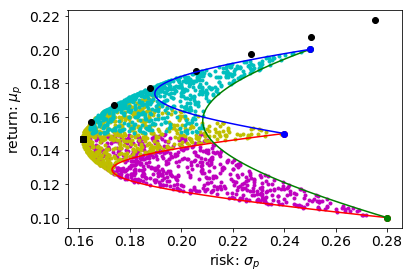

In [255]:
# Case of multiple assets

def port_retrisk(r0, cov, w):
    n = cov.shape[0]
    r = r0.reshape([n, 1])
    pr = np.dot(r.T, w.T)[0]
    ps = np.sqrt( np.sum(w.T * np.dot(cov, w.T), axis=0))
    return pr, ps

def minvarport(cov):
    n = cov.shape[0]
    u = np.ones([n]).reshape([n,1])
    cinv = np.linalg.inv(cov)
    return np.dot(u.T, cinv) / np.dot(np.dot(u.T, cinv), u)

def effrontier(r0, cov, lam=np.linspace(0,1,11)):
    n = cov.shape[0]
    r = r0.reshape([n, 1])
    efw = np.zeros([len(lam), n])  # weights
    efp = np.zeros([len(lam), 2])  # [return, std]
    u = np.ones([n]).reshape([n,1])
    cinv = np.linalg.inv(cov)
    for i in range(len(lam)):
        zeta = (1 - lam[i]*np.dot(u.T, np.dot(cinv, r))[0]) / np.sum(cinv, axis=(0,1))
        efw[i,:] = lam[i]*np.dot(cinv, r).reshape([1,n]) + zeta[0] * np.sum(cinv, axis=1).reshape([1,n])
    efp[:,0], efp[:,1] = port_retrisk(r, cov, efw)
    return efw, efp


r = np.array([0.1, 0.15, 0.2])
s = np.array([0.28, 0.24, 0.25])
cor = np.array([[1, -0.1, 0.25], 
                [-0.1, 1, 0.20], 
                [0.25, 0.20, 1]])
cov = cor * (np.dot(s.reshape([3,1]), s.reshape([3,1]).T))

# Monte-Carlo simulation
w = sampling_weight(nx=3, nsp=2000, flag=1)
pr, ps = port_retrisk(r, cov, w)
flag = np.argmax(w, axis=1)
cstr = list('myc')
for i in range(3):
    plt.plot(ps[flag==i], pr[flag==i], cstr[i]+'.')

# Minimum variance portfolio
wmvp = minvarport(cov)
print('Analytical MVP =', wmvp[0])
print('Sample MVP =', w[np.argmin(ps),:])
r_mvp, s_mvp = port_retrisk(r, cov, wmvp)
plt.plot( s_mvp, r_mvp, 'ks')

# Efficient frontier
lam = np.linspace(0, 0.7, 8)  # Lagrange multiplier
efw, efp = effrontier(r, cov, lam=lam)
plt.plot( efp[:,1], efp[:,0], 'ko')

# Every Pair
i=0; j=1; pr, ps = plot_2s(r=[r[i], r[j]], s=[s[i], s[j]], cor=cor[i,j], cstr='r')
i=0; j=2; pr, ps = plot_2s(r=[r[i], r[j]], s=[s[i], s[j]], cor=cor[i,j], cstr='g')
i=1; j=2; pr, ps = plot_2s(r=[r[i], r[j]], s=[s[i], s[j]], cor=cor[i,j], cstr='b')

plt.xlabel('risk: $\sigma_p$')
plt.ylabel('return: $\mu_p$')
plt.show()

### Tangent Portfolio

